# 메시지 삭제

그래프의 일반적인 상태 중 하나는 메시지 목록입니다. 일반적으로 해당 상태에 메시지를 추가만 합니다. 하지만 때로는 **메시지를 제거** 해야 할 수도 있습니다. 

이를 위해 `RemoveMessage` 수정자를 사용할 수 있습니다. 그리고, `RemoveMessage` 수정자는 `reducer` 키를 가진다는 것입니다. 

기본 `MessagesState`는 messages 키를 가지고 있으며, 해당 키의 reducer는 이러한 `RemoveMessage` 수정자를 허용합니다.

이 reducer는 `RemoveMessage`를 사용하여 키에서 메시지를 삭제합니다.

## 설정

먼저 메시지를 사용하는 간단한 그래프를 구축해보겠습니다. 필수적인 `reducer`를 포함하고 있는 `MessagesState`를 사용하고 있다는 점을 유의해주시기 바랍니다.

In [15]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [1]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


## 튜토리얼 진행을 위한 기본 LangGraph 를 구축

`RemoveMessage` 수정자를 사용하기 위해 필요한 기본 LangGraph 를 구축합니다.

In [2]:
from typing import Literal

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# 체크포인트 저장을 위한 메모리 객체 초기화
memory = MemorySaver()


# 웹 검색 기능을 모방하는 도구 함수 정의
@tool
def search(query: str):
    """Call to surf on the web."""
    return "웹 검색 결과: LangGraph 한글 튜토리얼은 https://wikidocs.net/233785 에서 확인할 수 있습니다."


# 도구 목록 생성 및 도구 노드 초기화
tools = [search]
tool_node = ToolNode(tools)

# 모델 초기화 및 도구 바인딩
model = ChatOpenAI(model_name="gpt-4o-mini")
bound_model = model.bind_tools(tools)


# # 대화 상태에 따른 다음 실행 노드 결정 함수
def should_continue(state: MessagesState):
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return END
    return "tool"


# LLM 모델 호출 및 응답 처리 함수
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("tool", tool_node)

# 시작점을 에이전트 노드로 설정
workflow.add_edge(START, "agent")

# 조건부 엣지 설정: 에이전트 노드 이후의 실행 흐름 정의
workflow.add_conditional_edges("agent", should_continue, {"tool": "tool", END: END})

# 도구 실행 후 에이전트로 돌아가는 엣지 추가
workflow.add_edge("tool", "agent")

# 체크포인터가 포함된 최종 실행 가능한 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)

그래프를 시각화합니다.

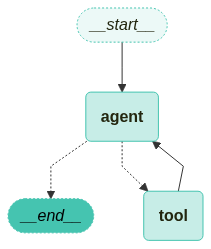

In [3]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [4]:
from langchain_core.messages import HumanMessage

# 스레드 ID가 1인 기본 설정 객체 초기화
config = {"configurable": {"thread_id": "1"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다."
)

# 스트림 모드로 메시지 처리 및 응답 출력, 마지막 메시지의 상세 정보 표시
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?


In [5]:
# 후속 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

# 스트림 모드로 두 번째 메시지 처리 및 응답 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다! 다른 질문이나 궁금한 점이 있으시면 말씀해 주세요.


In [6]:
# 단계별 상태 확인
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다! 다른 질문이나 궁금한 점이 있으시면 말씀해 주세요.


## RemoveMessage 수정자를 사용하여 메시지 삭제

먼저 메시지를 수동으로 삭제하는 방법을 살펴보겠습니다. 현재 스레드의 상태를 확인해보겠습니다:

In [7]:
# 앱 상태에서 메시지 목록 추출 및 저장
messages = app.get_state(config).values["messages"]
# 메시지 목록 반환
for message in messages:
    message.pretty_print()

================================ Human Message =================================

안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다! 다른 질문이나 궁금한 점이 있으시면 말씀해 주세요.


`update_state`를 호출하고 첫 번째 메시지의 id를 전달하면 해당 메시지가 삭제됩니다.

In [8]:
from langchain_core.messages import RemoveMessage

# 메시지 배열의 첫 번째 메시지를 ID 기반으로 제거하고 앱 상태 업데이트
app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f065d93-4e2c-6768-8005-f55a9a4769d7'}}

이제 메시지들을 확인해보면 첫 번째 메시지가 삭제되었음을 확인할 수 있습니다.

In [9]:
# 앱 상태에서 메시지 목록 추출 및 저장된 대화 내역 조회
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================

안녕하세요, Teddy님! 만나서 반갑습니다. 어떻게 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 Teddy입니다! 다른 질문이나 궁금한 점이 있으시면 말씀해 주세요.


## 더 많은 메시지를 동적으로 삭제

그래프 내부에서 프로그래밍 방식으로 메시지를 삭제할 수도 있습니다. 

그래프 실행이 종료될 때 오래된 메시지(3개 이전의 메시지보다 더 이전의 메시지)를 삭제하도록 그래프를 수정하는 방법을 살펴보겠습니다.

In [10]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import END


# 메시지 개수가 3개 초과 시 오래된 메시지 삭제 및 최신 메시지만 유지
def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}


# 메시지 상태에 따른 다음 실행 노드 결정 로직
def should_continue(state: MessagesState) -> Literal["action", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # 함수 호출이 없는 경우 메시지 삭제 함수 실행
    if not last_message.tool_calls:
        return "delete_messages"
    # 함수 호출이 있는 경우 액션 실행
    return "action"


# 메시지 상태 기반 워크플로우 그래프 정의
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# 메시지 삭제 노드 추가
workflow.add_node(delete_messages)

# 시작 노드에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 조건부 엣지 추가를 통한 노드 간 흐름 제어
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

# 액션 노드에서 에이전트 노드로 연결
workflow.add_edge("action", "agent")

# 메시지 삭제 노드에서 종료 노드로 연결
workflow.add_edge("delete_messages", END)

# 메모리 체크포인터를 사용하여 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)

그래프를 시각화합니다.

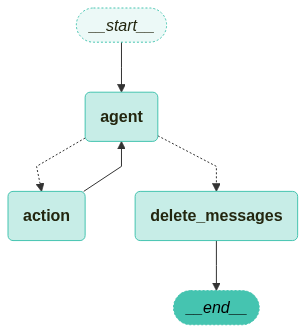

In [11]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

이제 이것을 시도해볼 수 있습니다. `graph`를 두 번 호출한 다음 상태를 확인할 수 있습니다.

In [12]:
# LangChain 메시지 처리를 위한 HumanMessage 클래스 임포트
from langchain_core.messages import HumanMessage

# 스레드 ID가 포함된 설정 객체 초기화
config = {"configurable": {"thread_id": "2"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다."
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.')]
[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 무엇을 도와드릴까요?')]


In [13]:
# 2번째 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 무엇을 도와드릴까요?'), ('human', '내 이름이 뭐라고요?')]
[('human', '안녕하세요! 제 이름은 Teddy입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 무엇을 도와드릴까요?'), ('human', '내 이름이 뭐라고요?'), ('ai', 'Teddy님이라고 하셨습니다. 맞나요?')]
[('ai', '안녕하세요, Teddy님! 만나서 반갑습니다. 무엇을 도와드릴까요?'), ('human', '내 이름이 뭐라고요?'), ('ai', 'Teddy님이라고 하셨습니다. 맞나요?')]


최종 상태를 확인해보면 메시지가 단 세 개만 있는 것을 확인할 수 있습니다. 

이는 이전 메시지들을 방금 삭제했기 때문입니다.

In [14]:
# 앱 상태에서 메시지 목록 추출 및 저장
messages = app.get_state(config).values["messages"]
# 메시지 목록 반환
for message in messages:
    message.pretty_print()

================================== Ai Message ==================================

안녕하세요, Teddy님! 만나서 반갑습니다. 무엇을 도와드릴까요?
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

Teddy님이라고 하셨습니다. 맞나요?
